# Recover a net from MetaGraph and continue training
Let's start by loading the data again

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


<IPython.core.display.Javascript object>


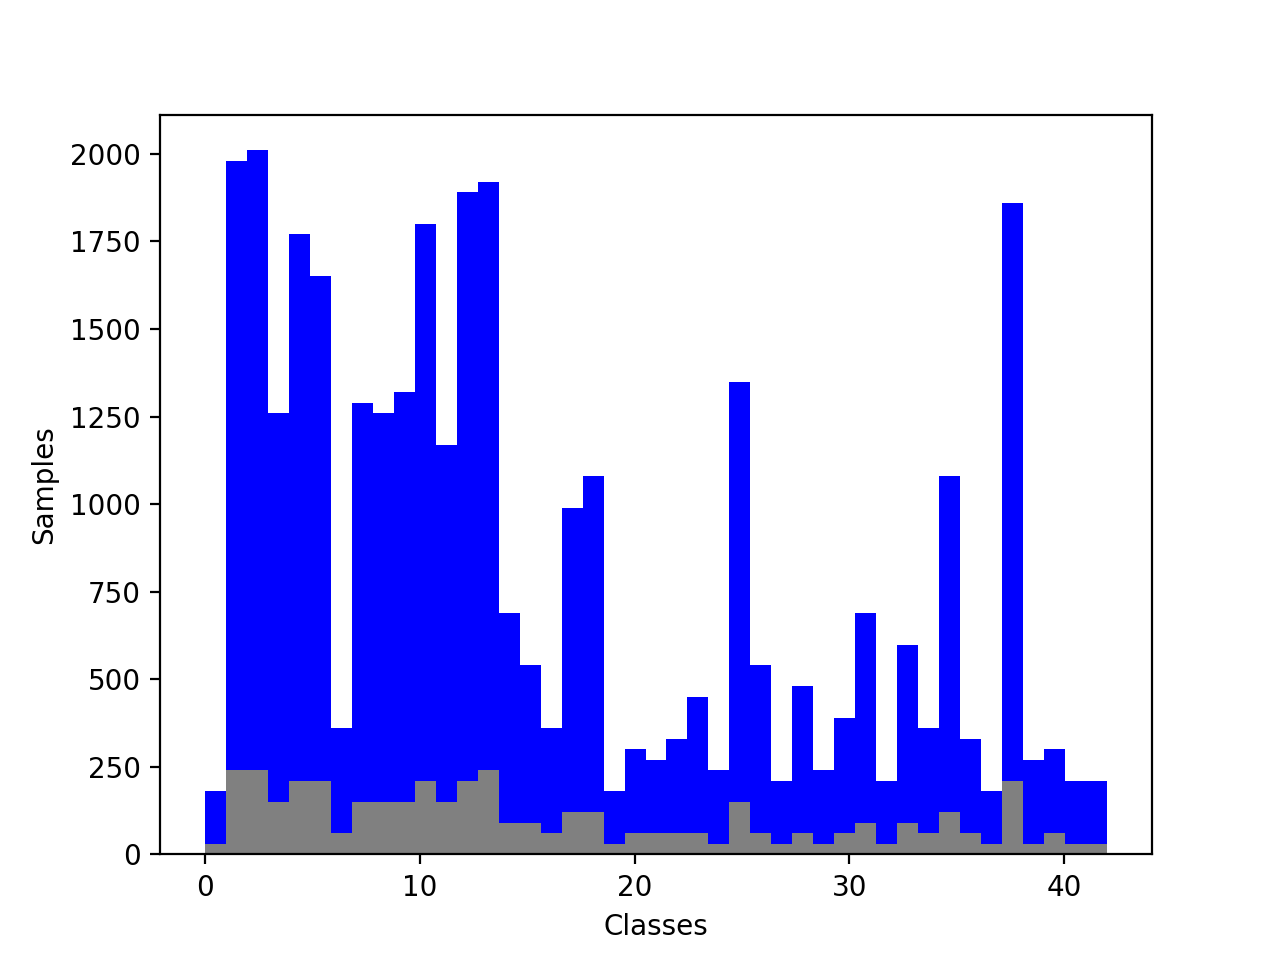

In [2]:
import pickle, os
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.utils import shuffle
% matplotlib notebook

# Load data

training_file = "traffic_signs-data/train.p"
validation_file = "traffic_signs-data/valid.p"
testing_file = "traffic_signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

class_labels = pd.read_csv("signnames.csv")

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = y_train.max() + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# the histogram of the data

n, bins, patches = plt.hist([y_valid, y_train], bins=n_classes, color=['grey', 'blue'], label=['val','train'], histtype='stepfilled')
plt.xlabel('Classes')
plt.ylabel('Samples')
plt.show()

In [4]:
# The dataset is very unbalanced. Therefore, it we need to rebalance it.
def balance_set(class_lables):
    train_class_indexes = [[] for _ in range(class_lables.max()+1)]
    n_samples = np.zeros(class_lables.max()+1)
    for i,l in enumerate(class_lables):
        train_class_indexes[l].append(i)
        n_samples[l]+=1
    
    for i, l in enumerate(train_class_indexes):
        size = len(l)
        for _ in range(int(n_samples.max())-size):
            train_class_indexes[i].append(l[np.random.randint(size)])
    
    train_class_indexes = np.reshape(np.array(train_class_indexes, dtype=np.int),[-1])
    train_class_indexes = shuffle(train_class_indexes)
    
    return train_class_indexes

trainset_balanced_ids = balance_set(y_train)

# Important step: import graph

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
new_saver = tf.train.import_meta_graph('logs/rebalanced_set/LeNet_with_collections/model.ckpt.meta', clear_devices=True)
last_checkpoint = tf.train.latest_checkpoint('logs/rebalanced_set/LeNet_with_collections')
new_saver.restore(sess, last_checkpoint)
graph = sess.graph.as_default()

# Extract net inputs and operations from the graph
#### by extracting them from graph collections

# This is the step that I am puzzeled by!#
When I import metagraph, I can access my inputs, activation layers, and main operations only if I added them to collections when I built the model.

However, all of my prior models were trained withough tf.add_to_collection. Does this mean that I won't be able to load and use them through a MetaGraph? Or am I mission something?

In [6]:
# Because we added inputs to tf.GraphKeys.RESOURCES collection
X, y = tf.get_collection(tf.GraphKeys.RESOURCES)
feature_map, predict_class_op, accuracy_op = tf.get_collection(tf.GraphKeys.ACTIVATIONS)
total_loss = tf.get_collection(tf.GraphKeys.LOSSES)
optimization_op = tf.get_collection(tf.GraphKeys.TRAIN_OP)

#### Now we can continue training.

A couple of standard utility functions:

In [7]:
def eval_step(X_batch, Y_batch):
    sess = tf.get_default_session()
    accuracy = sess.run(accuracy_op, feed_dict={X: X_batch, y: Y_batch})
    return accuracy


def fit_net(X_batch, Y_batch):
    sess = tf.get_default_session()
    _, accuracy = sess.run([optimization_op, accuracy_op],
                           feed_dict={X: X_batch,
                                      y: Y_batch})
    return accuracy


def evaluate_net(X, Y, batch_size):
    n_samples = len(X)
    accuracy = []
    pbar = range(0, n_samples, batch_size)
    for offset in pbar:
        start = offset
        end = start + batch_size
        batch_img = X[start:end]
        batch_labels = Y[start:end]
        a = eval_step(batch_img, batch_labels)
        accuracy.append(a)
    return np.mean(accuracy)


def train(trainset_balanced_ids, train_X, train_Y, validate_X, validate_Y, batch_size, n_epochs, path):
    # Initialize a saver class and variable initializer
    saver = tf.train.Saver()
    init = tf.global_variables_initializer()

    sess = tf.get_default_session()
    sess.run(init)

    summary_op = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(os.path.join(path, 'tensorboard/'), sess.graph)

    val_acc = 0.0
    pbar = tqdm(range(1, n_epochs + 1), leave=True)
    for i in pbar:
        trainset_balanced_ids = shuffle(trainset_balanced_ids)
        pbar.set_description("Epoch {}".format(i))
        for offset in range(0, len(trainset_balanced_ids), batch_size):
            start = offset
            end = start + batch_size
            batch_img = train_X[trainset_balanced_ids[start:end]]
            batch_labels = train_Y[trainset_balanced_ids[start:end]]

            a = fit_net(batch_img, batch_labels)

            pbar.set_postfix(accuracy="{:.1f}%".format(a * 100), val_accuracy="{:.1f}%".format(val_acc * 100))
            pbar.update(0)
        ### Calculate and report the accuracy on the training and validation set.
        val_acc = evaluate_net(validate_X, validate_Y, batch_size)
        saver.save(sess, os.path.join(path, 'model.ckpt'))
        summary_op_str = sess.run(summary_op,
                                  feed_dict={X: batch_img,
                                             y: batch_labels})
        summary_writer.add_summary(summary_op_str, i)

    pbar.close()
    print("Model was saved to {}".format(path))
    print("Final accuracy on validation set: {:.1f}%".format(val_acc * 100))

In [8]:
# Let's train!
train(trainset_balanced_ids, X_train, y_train, X_valid, y_valid, 512, 3, "logs/rebalanced_set/LeNet_with_collections/")

Epoch 3: 100%|██████████| 3/3 [04:41<00:00, 91.50s/it, accuracy=98.8%, val_accuracy=83.5%]

Model was saved to logs/rebalanced_set/LeNet_with_collections/
Final accuracy on validation set: 85.8%
